## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2023.

# Assignment 1, Task 3: Multilayer Perceptron (MLP)
This is the third part of the assignment. You will get to implement MLP using tensorflow

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 58000 samples from original training set of 60,000
# Validation data: 2000 samples from original training set: 58,000~60,000
# Test data: 10000 samples from original test set
# Development data (for gradient check): 100 from the training set

num_training = 58000
num_validation = 2000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(58000, 784) (2000, 784) (10000, 784) (100, 784)
Train data shape:  (58000, 784)
Train labels shape:  (58000,)
Validation data shape:  (2000, 784)
Validation labels shape:  (2000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


## Part 1: Tensorflow MLP (10%)
In this part, you will use tensorflow modules to implement an MLP. We provide a demo of a two-layer net, the style of is referenced from https://www.tensorflow.org/guide/keras and https://www.tensorflow.org/guide/eager. 

You need to implement a MLP with 4 layers in a similar style.

### Demo: Two-layer MLP in Tensorflow

In [3]:
## Demo: Two-layer net in tensorflow (eager execution mode)
hidden_dim = 300
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim, 20).astype('float32'))
        self.b2 = tf.Variable(np.zeros((20,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        out = tf.matmul(h1, self.W2) + self.b2
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 58000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 15
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.7490000128746033
epoch 2: valid acc = 0.7875000238418579
epoch 3: valid acc = 0.8199999928474426
epoch 4: valid acc = 0.8389999866485596
epoch 5: valid acc = 0.8410000205039978
epoch 6: valid acc = 0.8529999852180481
epoch 7: valid acc = 0.8619999885559082
epoch 8: valid acc = 0.8654999732971191
epoch 9: valid acc = 0.8659999966621399
epoch 10: valid acc = 0.8715000152587891
epoch 11: valid acc = 0.8734999895095825
epoch 12: valid acc = 0.8765000104904175
epoch 13: valid acc = 0.8765000104904175
epoch 14: valid acc = 0.8799999952316284
epoch 15: valid acc = 0.8790000081062317
test acc = 0.86080002784729


### Create Deeper Network

<span style="color:red"><strong>TODO</strong></span>: Create your MLP in tensorflow. Since you are going to create a deeper neural network, it is recommended to use "list" to store your network parameters (weights and bias). Consider using a loop to create your MLP network.

<span style="color:red"><strong>HINT</strong></span>: Copy the code above and make necessary changes in model definition.

In [4]:
# Create you MLP using TensorFlow functions.

## Demo: Two-layer net in tensorflow (eager execution mode)
hidden_dim = 300
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim, 20).astype('float32'))
        self.b2 = tf.Variable(np.zeros((20,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        out = tf.matmul(h1, self.W2) + self.b2
        return out
    
class DeepMLP(tf.keras.Model):
    def __init__(self, input_dim, hidden_dims, num_classes=20):
        super(DeepMLP, self).__init__()
        self.layers_list = []
        
        # Input layer to first hidden layer
        self.layers_list.append(tf.Variable(1e-2 * np.random.rand(input_dim, hidden_dims[0]).astype('float32')))
        self.layers_list.append(tf.Variable(np.zeros((hidden_dims[0],)).astype('float32')))
        
        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            self.layers_list.append(tf.Variable(1e-2 * np.random.rand(hidden_dims[i], hidden_dims[i+1]).astype('float32')))
            self.layers_list.append(tf.Variable(np.zeros((hidden_dims[i+1],)).astype('float32')))
        
        # Last hidden layer to output
        self.layers_list.append(tf.Variable(1e-2 * np.random.rand(hidden_dims[-1], num_classes).astype('float32')))
        self.layers_list.append(tf.Variable(np.zeros((num_classes,)).astype('float32')))

    def call(self, inputs):
        """Run the model."""
        for i in range(0, len(self.layers_list) - 2, 2):
            inputs = tf.nn.relu(tf.matmul(inputs, self.layers_list[i]) + self.layers_list[i+1])
        out = tf.matmul(inputs, self.layers_list[-2]) + self.layers_list[-1]
        return out
'''
deep_model = Model()

# Initialize the deeper model
hidden_dims = [300, 200, 100]  
deep_model = DeepMLP(X_train.shape[1], hidden_dims)'''

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 58000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 15
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.7294999957084656
epoch 2: valid acc = 0.7829999923706055
epoch 3: valid acc = 0.8209999799728394
epoch 4: valid acc = 0.8345000147819519
epoch 5: valid acc = 0.8475000262260437
epoch 6: valid acc = 0.8514999747276306
epoch 7: valid acc = 0.8535000085830688
epoch 8: valid acc = 0.8585000038146973
epoch 9: valid acc = 0.8654999732971191
epoch 10: valid acc = 0.8669999837875366
epoch 11: valid acc = 0.8675000071525574
epoch 12: valid acc = 0.8679999709129333
epoch 13: valid acc = 0.8675000071525574
epoch 14: valid acc = 0.8684999942779541
epoch 15: valid acc = 0.8700000047683716
test acc = 0.8593000173568726


## Part 2: Introduction to TensorFlow.keras (10%)

As you can see, when the network structure becomes larger, it is hard to handle variables from every layer. Here we introduce the `tf.keras` tool to build the network in a much simpler way. You may want to use it in your project.

<span style="color:red"><strong>TODO</strong></span>: Follow this official example: https://www.tensorflow.org/datasets/keras_example#step_2_create_and_train_the_model to build an MLP and train it. 

*You should keep the same optimizer (SGD) and loss function (cross entropy) as in the previous task.*

**Note:** Since we want to use our own dataset, we will not use the `tfds.load` method to load the data this time. 

You need to check the usage of [`model.fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) and feed the model with our own data.

**Tips:**
* Softmax is also registered as a layer operation in tf.keras.
* You can use `model.summary()` to visualize the model after you build it.
* Use `verbose=2` in `model.fit()` to get similar training logs

In [5]:
#############################################################
# TODO: build the model with tf.keras.models.Sequential
model = tf.keras.models.Sequential([
    # First dense layer
    tf.keras.layers.Dense(300, activation='relu', input_shape=(X_train.shape[1],)),
    # Second dense layer
    tf.keras.layers.Dense(200, activation='relu'),
    # Third dense layer
    tf.keras.layers.Dense(100, activation='relu'),
    # Output layer with softmax activation for classification
    tf.keras.layers.Dense(20, activation='softmax')
])

model.summary()
# END of your code
#############################################################



#############################################################
# TODO: compile the model, set optimizer and loss

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# END of your code
#############################################################



#############################################################
# TODO: train the model with our own dataset
history = model.fit(X_train, y_train, epochs=15, batch_size=500, validation_data=(X_val, y_val), verbose=2)
# END of your code
#############################################################

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               60200     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2020      
Total params: 317,820
Trainable params: 317,820
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
116/116 - 1s - loss: 5.1901 - accuracy: 0.7059 - val_loss: 2.2657 - val_accuracy: 0.7545
Epoch 2/15
116/116 - 0s - loss: 1.7933 - accuracy: 0.7738 - val_loss: 1.6044 - val_accuracy: 0.7660
Epoch 3/15
116/116 - 0s - loss: 1.2827 - accurac

## Part 3: t-SNE (5%)

**t-SNE** is is a machine learning algorithm for nonlinear dimensionality reduction developed by *Geoffrey Hinton* and *Laurens van der Maaten*. It can be used as a good way of visualizing high-dimensional data in 2D.

Here we show its application for CIFAR100. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

In [6]:
from utils.train_funcs import train, test
from utils.classifiers.mlp import MLP

In [7]:
# Load the raw Fashion-MNIST data.
train_data, test_data = fashion_mnist.load_data()

X_train_raw, y_train = train_data
X_test_raw, y_test = test_data

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 58000 samples from original training set of 60,000
# Validation data: 2000 samples from original training set: 58,000~60,000
# Test data: 10000 samples from original test set
# Development data (for gradient check): 100 from the training set
num_training = 58000
num_validation = 2000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(58000, 784) (2000, 784) (10000, 784) (100, 784)
Train data shape:  (58000, 784)
Train labels shape:  (58000,)
Validation data shape:  (2000, 784)
Validation labels shape:  (2000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


### t-SNE of Original Data

In [8]:
!pip install scikit-learn

<font color="red">**NOTE**</font>: You may have to restart the kernel before proceeding.

it takes 2.683938503265381 seconds


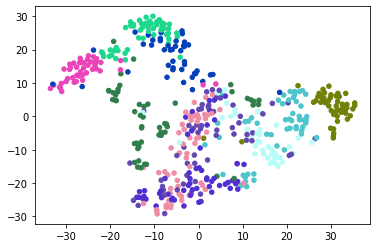

In [9]:
from sklearn.manifold import TSNE

random_select = np.random.choice(10000, 500, replace=False)
X = X_test_raw[random_select,:,:].reshape(500,X_train.shape[1]).astype('float')/255.0

tic = time.time()
Y = TSNE(n_components=2, perplexity=25.0).fit_transform(X)
print("it takes {} seconds".format(time.time()-tic))

## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

### t-SNE of Data After Two Hidden Layers

Do visualization of the tSNE of data after going through MLP. In the visualization result, you should find that in comparison with the t-SNE of original data where all data points mess up with each other. Visualization of data after two-layer networks would be shown as multiple clusters in a 2D panel.

In [22]:
# Define MLP model
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100], num_classes=20, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 290
epoch 1: valid acc = 0.825, new learning rate = 0.00095
epoch 2: valid acc = 0.84, new learning rate = 0.0009025
epoch 3: valid acc = 0.852, new learning rate = 0.000857375
epoch 4: valid acc = 0.8575, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.863, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.8685, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.87, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.8755, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.879, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.8845, new learning rate = 0.0005987369392383785
test acc: 0.8693


0.8693

<span style="color:red"><strong>TODO</strong></span>: Visualize data that is passed through MLP model defined above using tSNE. 

In [12]:
from utils.layer_utils import AffineLayer
# run tSNE
tic = time.time()

#############################################################################
#                          START OF YOUR CODE                               #
# Hint: Pass data through affine and dense layers (model.layers) and then 
# apply softmax to obtain output of the MLP model.
#############################################################################
num_samples = 58000
idx = np.random.choice(X_train.shape[0], num_samples, replace=False)
X_sample = X_train[idx]
y_sample = y_train[idx]

# Pass the sampled data through the AffineLayer
affine_activations = X_sample
for layer in model.layers:
    if isinstance(layer, AffineLayer):
        affine_activations = layer.feedforward(affine_activations)

from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca_results = pca.fit_transform(affine_activations)

# Now, use t-SNE on PCA results
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=123)
tsne_results = tsne.fit_transform(pca_results)


#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

it takes 645.1906876564026 seconds


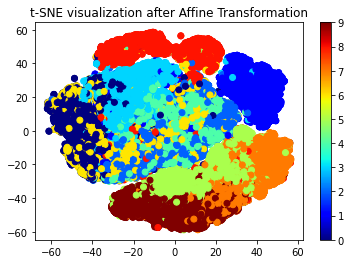

In [13]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
# Hint: See tSNE visualization of original data
#############################################################################
import matplotlib.pyplot as plt

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_sample, cmap='jet')
plt.colorbar()
plt.title("t-SNE visualization after Affine Transformation")
plt.show()
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

<span style="color:red"><strong>TODO</strong></span>: Try tuning the parameters of t-SNE. Do visualization of the new t-SNE of data.

In [14]:
# Tune the parameter, show the results.
# run tSNE
tic = time.time()

#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Sample t-SNE parameters
perplexities = [5, 30, 50]
learning_rates = [10, 100, 1000]
n_iters = [250, 1000, 2000]
early_exaggeration = [4.0, 12.0]

# For simplicity, let's just loop over perplexities and learning rates
for perp in perplexities:
    for lr in learning_rates:
        tsne = TSNE(perplexity=perp, n_iter=n_iters[1], learning_rate=lr, early_exaggeration=early_exaggeration[1])
        tsne_results = tsne.fit_transform(pca_results)


        
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

it takes 5897.386271476746 seconds


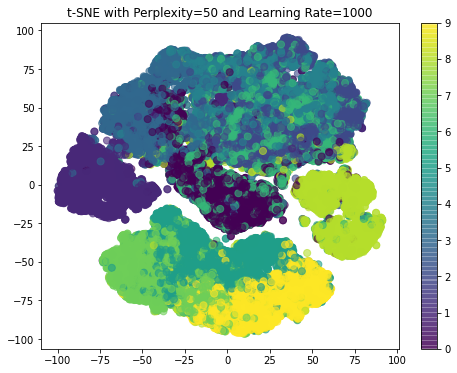

In [16]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_sample, cmap='viridis', s=50, alpha=0.6)
plt.colorbar()
plt.title(f't-SNE with Perplexity={perp} and Learning Rate={lr}')
plt.show()


#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################